## This notebook has been prepared for a session as part of the NLP course at University of Applied Sciences, Augsburg, Germany taught in 2023
### Author: Dr. Saurabh Kumar
### The course is taught by Prof. Alessandra Zarcone https://www.hs-augsburg.de/Informatik/Alessandra-Zarcone.html

### The main motivations for this code:
*  Understanding sentence embeddings in the context of semantic similarity
*  Understanding the simplicity, advantages, limitations and opportunities

### Let us use the example sentences from the course slides

Note: Many example sentences later have been used from Wikipedia text related to the topic in the sentence.

In [1]:
sentences = [
    "Paris is the capital of France",
    "Berlin is the capital of Germany",
    "French is a Romance language of the Indo-European family",
    "German is an Indo-European language which belongs to the West Germanic group of Germanic languages",
]

In [2]:
# Let us create a list of simple labels for sentences for easy plotting and printing
sent_labels = [
    "S1",
    "S2",
    "S3",
    "S4"
]

## How can we create sentence level embeddings based on word embeddings learnt earlier in the course?

### *fastText* is an open source library to learn text representation. The authors also provide pretrained embeddings for many languages.
### https://fasttext.cc/docs/en/english-vectors.html
### To understand the details of the used methods, refer the paper
[Advances in Pre-Training Distributed Word Representations](https://aclanthology.org/L18-1008) (Mikolov et al., LREC 2018)

In [3]:
! pip install fasttext

In [4]:
import fasttext.util

<div class="alert alert-block alert-warning">
The embedding files as well as some models used require significant storage space and RAM.
Please ensure that you have approximately 12Gb of free disk space and at least 16 Gb of RAM
</div>

### Let us download the word vectors for English


In [5]:
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [6]:
ft_en_model = fasttext.load_model('cc.en.300.bin')

### A simple method to get a sentence embedding from individual word embeddings could be to calculate the mean of the normalised embedding vectors
### For a sentence of the form  *w1* *w2* *w3* *w4* *w5* *w6*
### If the individual embedding vectors are  *v1*, *v2*, *v3*, *v4*, *v5*, *v6* then the sentence embedding can be calculated as
$$ \frac{\frac{{{v_1}}}{\|v_1\|}+\frac{{{v_2}}}{\|v_2\|}+\frac{{{v_3}}}{\|v_3\|}+\frac{{{v_4}}}{\|v_4\|}+\frac{{{v_5}}}{\|v_5\|}+\frac{{{v_6}}}{\|v_6\|}}{6} $$

### Let us try to do it for the words in the first sentence

In [7]:
import numpy as np

In [8]:
# Here is a very simple to understand (but probably not very efficient) function to generate the normalised vector
def normalize_vector(vec):
    norm = np.sqrt(np.sum(vec**2))
    if not norm==0:
        return vec/norm
    else:
        return vec

In [9]:
vec1 = normalize_vector(ft_en_model.get_word_vector('Paris'))
vec2 = normalize_vector(ft_en_model.get_word_vector('is'))
vec3 = normalize_vector(ft_en_model.get_word_vector('the'))
vec4 = normalize_vector(ft_en_model.get_word_vector('capital'))
vec5 = normalize_vector(ft_en_model.get_word_vector('of'))
vec6 = normalize_vector(ft_en_model.get_word_vector('France'))

In [10]:
# Calculate the sentence embedding and print the first ten elements
sent_vec = (vec1+vec2+vec3+vec4+vec5+vec6)/6.0
print(sent_vec[0:10])

[-0.00648477 -0.01590857 -0.02449585 -0.00863768 -0.00655541  0.00647134
  0.01945119 -0.00058179 -0.03748131  0.01811352]


### *fasttext* provides a function to do this for us

In [11]:
vec_s1 = ft_en_model.get_sentence_vector(sentences[0])
print(vec_s1[0:10])


[-0.00648477 -0.01590858 -0.02449585 -0.00863767 -0.00655541  0.00647135
  0.01945119 -0.00058179 -0.03748131  0.01811352]


In [13]:
vec_s2 = ft_en_model.get_sentence_vector(sentences[1])
vec_s3 = ft_en_model.get_sentence_vector(sentences[2])
vec_s4 = ft_en_model.get_sentence_vector(sentences[3])

### To find the similarity between the embedding vectors, let us use *cosine similarity*

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
vectors = np.array([vec_s1,vec_s2,vec_s3,vec_s4])
sim_score = cosine_similarity(vectors, vectors)

In [17]:
print('Cosine Similarities \
      \n S1-S2: {}\n S3-S4: {}\n S1-S3: {}\n S2-S4: {}\n S1-S4: {}\n S2-S3: {}\n'.format(
    sim_score[0][1], sim_score[2][3], sim_score[0][2], sim_score[1][3], sim_score[0][3], sim_score[1][2]))

Cosine Similarities       
 S1-S2: 0.890483558177948
 S3-S4: 0.8738839030265808
 S1-S3: 0.7206969857215881
 S2-S4: 0.7458847165107727
 S1-S4: 0.6785441040992737
 S2-S3: 0.6888570785522461



### An easy way to visualise similarities is using a heat map
#### We can use seaborn to do this. Install the dependencies if not already installed.

In [ ]:
! pip install seaborn
! pip install pandas
! pip install matplotlib

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [20]:
def plot_similarity_heatmap(dataframe):
    norm = mcolors.Normalize(0.0,1)
    fig=plt.figure(figsize=(4,4))
    hmap = sns.heatmap(dataframe, annot=True,norm=norm)
    hmap.set_xticklabels(hmap.get_xticklabels(), rotation = 45)
    plt.tight_layout()    

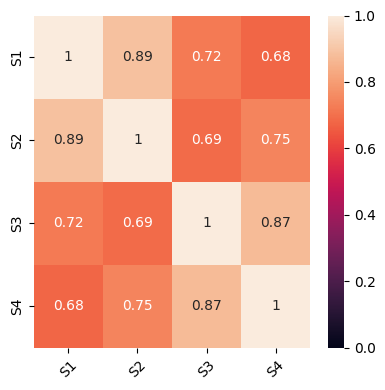

In [21]:
similarity_df_1 = pd.DataFrame(data=np.array(sim_score),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_1)

### Not all sentences have similarities as we expect. E.g. Similarity between s1 and s4 is too high.
### If we extract only the *'most relevant'* words for *'our understanding'* of the most significant themes in these sentences, what would happen?
### Remember that we use only the average of the normalised embeddings. So the order of the words does not play a role.

In [22]:
sentences1 = [
    "Paris capital France",
    "Berlin capital Germany",
    "French language",
    "German language",
]
vec_s1 = ft_en_model.get_sentence_vector(sentences1[0])
vec_s2 = ft_en_model.get_sentence_vector(sentences1[1])
vec_s3 = ft_en_model.get_sentence_vector(sentences1[2])
vec_s4 = ft_en_model.get_sentence_vector(sentences1[3])
vectors2 = np.array([vec_s1,vec_s2,vec_s3,vec_s4])
sim_score2 = cosine_similarity(vectors2, vectors2)

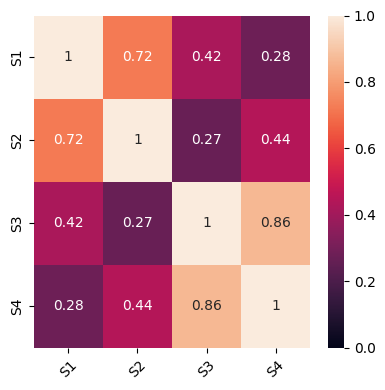

In [23]:
similarity_df_2 = pd.DataFrame(data=np.array(sim_score2),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_2)

### What happens with complex sentences representing complex themes or concepts?
    "France is a representative democracy organised as a unitary, semi-presidential republic",
    "Germany is a federal, parliamentary, representative democratic republic",
    "Germany is famous for beer and cars",
    "France is famous for cheese and wine"

In [24]:
sentences2 = [
    "France is a representative democracy organised as a unitary semi-presidential republic",
    "Germany is a federal parliamentary representative democratic republic",
    "Germany is famous for beer and cars",
    "France is famous for cheese and wine",
]
vec_s1 = ft_en_model.get_sentence_vector(sentences2[0])
vec_s2 = ft_en_model.get_sentence_vector(sentences2[1])
vec_s3 = ft_en_model.get_sentence_vector(sentences2[2])
vec_s4 = ft_en_model.get_sentence_vector(sentences2[3])
vectors3 = np.array([vec_s1,vec_s2,vec_s3,vec_s4])
sim_score3 = cosine_similarity(vectors3, vectors3)

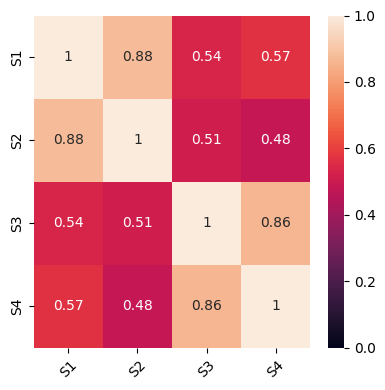

In [25]:
similarity_df_3 = pd.DataFrame(data=np.array(sim_score3),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_3)

### We notice the same problems as seen earlier. E.g. The S1 and S3 embeddings have the same cosine similarity as S1 and S4.
### Let us try our trivial method of removing the *'unwanted'* words and retaining the *'meaning'*

In [26]:
sentences3 = [
    "France representative democracy organised unitary semi-presidential republic",
    "Germany federal parliamentary representative democratic republic",
    "Germany famous beer cars",
    "France famous cheese wine",
]
vec_s1 = ft_en_model.get_sentence_vector(sentences3[0])
vec_s2 = ft_en_model.get_sentence_vector(sentences3[1])
vec_s3 = ft_en_model.get_sentence_vector(sentences3[2])
vec_s4 = ft_en_model.get_sentence_vector(sentences3[3])
vectors4 = np.array([vec_s1,vec_s2,vec_s3,vec_s4])
sim_score4 = cosine_similarity(vectors4, vectors4)

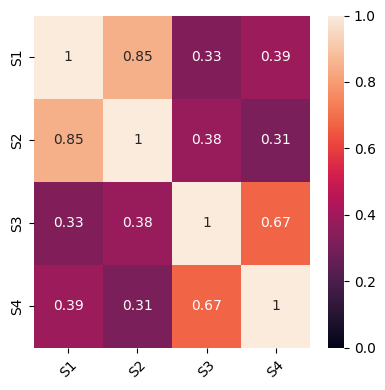

In [27]:
similarity_df_4 = pd.DataFrame(data=np.array(sim_score4),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_4)

### A simple method like averaging of normalised embeddings can be quite powerful. This, together with *weighting* schemes have been shown to be quite effective.
### Refer the paper 
[A simple but tough-to-beat baseline for sentence embeddings](https://openreview.net/pdf?id=SyK00v5xx) (Arora, S., Liang, Y., & Ma, T. 2019)

### In spite of this performance, it is not allways feasible to obtain such results by just removing *'stop words'*. It becomes more challenging with longer sentences within a given domain and capturing context. Additionally, it is not easy to adapt a trained embedding model to provide *'higher'* or *'lower'* similarity based on a dataset of *'labelled'* examples. Using weighting schmes like SIF are challenging for out of domain usage.

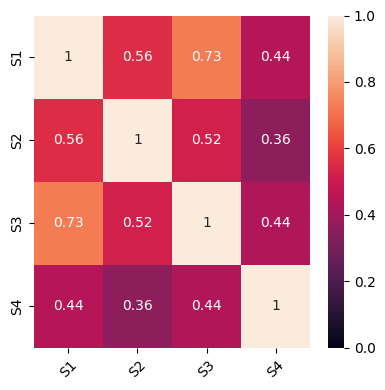

In [28]:
sentences4 = [
    "France has a developed high-income mixed economy characterised by sizeable government involvement economic diversity a skilled labour force and high innovation. For roughly two centuries the French economy has consistently ranked among the ten largest globally.",
    "Germany is a federal, parliamentary, representative democratic republic. Federal legislative power is vested in the parliament consisting of the Bundestag (Federal Diet) and Bundesrat (Federal Council), which together form the legislative body.",
    "With a population of 80.2 million according to the 2011 German Census, rising to 83.7 million as of 2022, Germany is the most populous country in the European Union, the second-most populous country in Europe after Russia, and the nineteenth-most populous country in the world.",
    "Each region of France has iconic traditional specialties: cassoulet in the Southwest, choucroute in Alsace, quiche in the Lorraine region, beef bourguignon in Burgundy, provençal tapenade, etc.",
]

# Try removing some stop words as before (this is a manual experiment - try experimenting with different stop word sets yourself)
sentences4_1 = [
    "France developed high-income mixed economy characterised by sizeable government involvement economic diversity skilled labour force high innovation. For roughly two centuries French economy consistently ranked among ten largest globally",
    "Germany federal parliamentary representative democratic republic. Federal legislative power vested parliament consisting Bundestag (Federal Diet) Bundesrat (Federal Council) which together form legislative body",
    "With population 80.2 million according 2011 German Census rising  83.7 million 2022 Germany most populous country European Union second-most populous country Europe after Russia nineteenth-most populous country world",
    "Each region France iconic traditional specialties: cassoulet Southwest choucroute Alsace quiche Lorraine region beef bourguignon Burgundy provençal tapenade",
]
vec_s1 = ft_en_model.get_sentence_vector(sentences4_1[0])
vec_s2 = ft_en_model.get_sentence_vector(sentences4_1[1])
vec_s3 = ft_en_model.get_sentence_vector(sentences4_1[2])
vec_s4 = ft_en_model.get_sentence_vector(sentences4_1[3])
vectors5 = np.array([vec_s1,vec_s2,vec_s3,vec_s4])
sim_score5 = cosine_similarity(vectors5, vectors5)
similarity_df_5 = pd.DataFrame(data=np.array(sim_score5),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_5)

## What else is feasible?

### The Attention mechanism and Transformers introduced new methods for natural language modelling. BERT adapted trnsformers to a combination of unsupervised learning (masked language modelling and next sentence prediction) followed by supervised finetuning.
### These methods introduced a new method for capturing context in long text sequences.
### We do not cover all these here now but the semantic similarity task creates a nice motivation for understanding what these methods could mean for such a task.
### Refer the paper
[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf) (Devlin e.al. 2019)


### However, BERT embeddings directly are not directly useful to achieve a better peformance than averaging word embeddings.
### The following paper showed a new method to pool BERT embeddings and achieve significantly superior performnace on many benchmark tasks.
[Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf) (Reimers, Nils and Gurevych, Iryna 2019)

## We explore this using the sentence-transformers library
#### We have to be thankful to Nils Reimers and other team members for this excellent and well documented library.

#### Try to Free up some RAM before loading other models. Remember that Python uses a garbage collector and deleting the reference will not immediately free up memory.

In [29]:
del ft_en_model

In [ ]:
!pip install sentence-transformers

In [31]:
from sentence_transformers import SentenceTransformer

/home/devops/python_envs/sbert_mlflow_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# We use a small model due to memory constraints. You can also try larger models like 'all-roberta-large-v1' if you have more RAM
# If you get error messages that the kernel died, the most probable reason is lack of RAM
sbert_model = SentenceTransformer('all-distilroberta-v1')

### We can modify the sentence lists to have some with higher expected similarity and others with lower expected similarity

In [33]:
sentences5 = [
    "France has a developed high-income mixed economy characterised by sizeable government involvement economic diversity a skilled labour force and high innovation. For roughly two centuries the French economy has consistently ranked among the ten largest globally.",
    "French economy is the world's seventh-largest economy by nominal GDP",
    "Germany is a federal, parliamentary, representative democratic republic. Federal legislative power is vested in the parliament consisting of the Bundestag (Federal Diet) and Bundesrat (Federal Council), which together form the legislative body.",
    "With a population of 80.2 million according to the 2011 German Census, rising to 83.7 million as of 2022, Germany is the most populous country in the European Union, the second-most populous country in Europe after Russia, and the nineteenth-most populous country in the world.",
    "Each region of France has iconic traditional specialties: cassoulet in the Southwest, choucroute in Alsace, quiche in the Lorraine region, beef bourguignon in Burgundy, provençal tapenade, etc.",
    "A typical French Christmas dish is turkey with chestnuts."
]
sent_labels = [
    "S1",
    "S2",
    "S3",
    "S4",
    "S5",
    "S6"
]

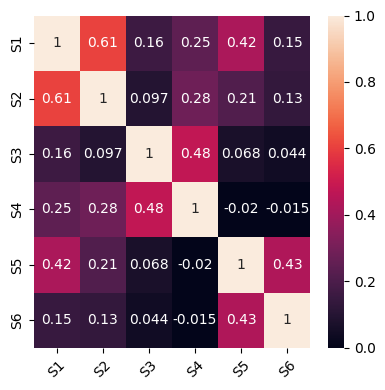

In [34]:
vectors6 = sbert_model.encode(sentences5,convert_to_numpy=True,normalize_embeddings=True)
sim_score6 = cosine_similarity(vectors6, vectors6)
similarity_df_6 = pd.DataFrame(data=np.array(sim_score6),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_6)

### If we expect that for our context, French economy and French Cuisine have to be treated as separate *'concepts'* and should have a low similarity, then we have a problem with above results.
### The similarity Between S1 and S5 is quite high.
#### There are other issues with sentences S2 and S4, or separation between topics realted to S3 and S4 but we do not discuss them for now.
### Can we change this?
### The answer lies in finetuning the model (using supervision)


In [36]:
from sentence_transformers import SentencesDataset, InputExample, losses
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader

### But we need labelled data to do the finetuning. 
### The sentences below about french economy, french cuisine,  french governance and french demographics are taken from the respective Wikipedia pages.
#### https://en.wikipedia.org/wiki/Economy_of_France
#### https://en.wikipedia.org/wiki/French_cuisine


In [37]:
french_economy = [
    "The economy of France is a highly developed social market economy with notable state participation in strategic sectors.",
    "French economy is the world's seventh-largest economy by nominal GDP and the tenth-largest economy by PPP, constituting around 4% of world GDP.",
    "France has a diversified economy, that is dominated by the service sector (which in 2017 represented 78.8% of its GDP), whilst the industrial sector accounted for 19.5% of its GDP and the primary sector accounted for the remaining 1.7%.",
    "France's economy entered the recession of the late 2000s later and appeared to leave it earlier than most affected economies, only enduring four-quarters of contraction.",
    "The Government of France has run a budget deficit each year since the early 1970s. As of 2021, French government debt reached an equivalent of 118.6% of French GDP.",
    #"The leading industrial sectors in France are telecommunications (including communication satellites), aerospace and defense, ship building (naval and specialist ships), pharmaceuticals, construction and civil engineering, chemicals, textiles, and automobile production.",
    #"France is the world-leading country in nuclear energy, home of global energy giants Areva, EDF and GDF Suez",
    #"France is the world's sixth largest agricultural producer and EU's leading agricultural power, accounting for about one-third of all agricultural land within the EU.",
    #"As the world's second-largest agricultural exporter, France ranks just after the United States.",
    #"France is the world's most popular tourist destination with more than 83.7 million foreign tourists in 2014, ahead of Spain (58.5 million in 2006) and the United States "
    #"France has long suffered a relatively high unemployment rate, even during the years when its macroeconomic performances compared favorably with other advanced economies.",
    #"In 2018, France was the 5th largest trading nation in the world, as well as the second-largest trading nation in Europe"
]

french_cuisine = [
    "French cuisine is the cooking traditions and practices from France.",
    "Cheese and wine are a major part of the French cuisine.",
    "Culinary tourism and the Guide Michelin helped to acquaint commoners with the cuisine bourgeoise of the urban elites and the peasant cuisine of the French countryside starting in the 20th century.",
    "Knowledge of French cooking has contributed significantly to Western cuisines.",
    "In French medieval cuisine, banquets were common among the aristocracy.",
    #"Markets in Paris were very important to the distribution of food.",
    #"During the 16th and 17th centuries, French cuisine assimilated many new food items from the New World.",
    #"The French Revolution was integral to the expansion of French cuisine, because it abolished the guild system.",
    #"In French provinces, bread was often consumed three times a day by the people of France.",
    #"Georges Auguste Escoffier is commonly acknowledged as the central figure to the modernization of haute cuisine and organizing what would become the national cuisine of France.",
    #"The term nouvelle cuisine has been used many times in the history of French cuisine which emphasized the freshness, lightness and clarity of flavor and inspired by new movements in world cuisine."
    #"Over 9,000 restaurants exist in Paris and almost any cuisine can be obtained here.",
    #"French Guianan cuisine or Guianan cuisine is a blend of the different cultures that have settled in French Guiana.",
    #"French cuisine varies according to the season."
]

french_governance = [
    "France is a representative democracy organised as a unitary, semi-presidential republic.",
    "As one of the earliest republics of the modern world, democratic traditions and values are deeply rooted in French culture, identity and politics.",
    "The legislature consists of the French Parliament, a bicameral body made up of a lower house, the National Assembly and an upper house, the Senate."
]

french_demographics = [
    "With an estimated January 2023 population of 68,042,591 people, France is the 20th most populous country in the world, the third-most populous in Europe, and the second most populous in the European Union",
    "France is an outlier among developed countries, particularly in Europe, for its relatively high rate of natural population growth",
    "Like many developed nations, the French population is aging; the average age is 41.7 years, while about a fifth of French people are 65 or over"
]

### We will try to use this small set of data to generate a sufficiently big dataset for finetuning. 
#### Remember that this is just a demonstrative example. Actual finetuning for a specific domain needs a better curated dataset.
### We provide labels where sentences across topics are labelled to have a low similarity and sentences within topics are assigned a high similarity.

In [38]:
import itertools

In [39]:
train_examples = []
for sentence_pairs in itertools.product(french_economy, french_cuisine):
    train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.1))

for sentence_pairs in itertools.product(french_economy, french_economy):
    if sentence_pairs[0] != sentence_pairs[1]:
        train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.7))
        
for sentence_pairs in itertools.product(french_cuisine, french_cuisine):
    if sentence_pairs[0] != sentence_pairs[1]:
        train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.7))
        
for sentence_pairs in itertools.product(french_economy, french_governance):
    train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.1))  
        
for sentence_pairs in itertools.product(french_economy, french_demographics):
    train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.1))  

for sentence_pairs in itertools.product(french_governance, french_demographics):
    train_examples.append(InputExample(texts=[sentence_pairs[0],sentence_pairs[1]],label=0.1))  
    
print('Num of training samples: {}'.format(len(train_examples)))

Num of training samples: 104


In [40]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=4)
train_loss = losses.CosineSimilarityLoss(model=sbert_model)

sbert_model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=5,
          warmup_steps=10)

Iteration:   4%|███▍                                                                                    | 1/26 [00:02<00:57,  2.31s/it]


Iteration:  12%|██████████▏                                                                             | 3/26 [00:06<00:46,  2.00s/it]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:32<00:00, 54.58s/it]


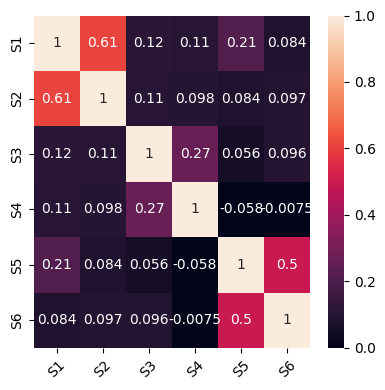

In [41]:
vectors7 = sbert_model.encode(sentences5,convert_to_numpy=True,normalize_embeddings=True)
sim_score7 = cosine_similarity(vectors7, vectors7)
similarity_df_7 = pd.DataFrame(data=np.array(sim_score7),index=sent_labels, columns=sent_labels)
plot_similarity_heatmap(similarity_df_7)

#### If this has lit up your imagination:
* You can try to reduce/increase the number of sentences or add more variety and see what happens (comment uncomment the sentences)
* Change the batch size and the number of epochs and experiment with finetuning.
* Read the documentation on the sbert website and look at the github code.
* Important hint: warmup_steps can be taken as approximately 10% of training sample size.
* Beware of memory requirements. If you get error message related to dead kernel, watch out for the memory.

#### After having learnt about Transformers and BERT in later part of the course, you can start the domain adaptation from the base models (e.g. RoBERTa). Just arrange for the required computation power (or get your gaming machine to do something different ).

### Here is something to think about later and practice:
### Could this have been done by using Wikipedia text for economy and cuisine instead of french economy and french cuisine?
#### Texts taken from:
#### https://en.wikipedia.org/wiki/Economy
#### https://en.wikipedia.org/wiki/Cuisine
### Try to run some experiments and see what happens.

In [42]:
economy = [
    "An economy is an area of the production, distribution and trade, as well as consumption of goods and services.",
    "A given economy is a set of processes that involves its culture, values, education, technological evolution, history, social organization, political structure, legal systems, and natural resources as main factors.",
    "A market economy is one where goods and services are produced and exchanged according to demand and supply between participants (economic agents) by barter or a medium of exchange with a credit or debit value accepted within the network, such as a unit of currency.",
    "The gross domestic product (GDP) of a country is a measure of the size of its economy, or more specifically, monetary measure of the market value of all the final goods and services produced.",
    "In the Middle Ages, what is now known as an economy was not far from the subsistence level. Most exchange occurred within social groups.", 
    "As long as someone has been making, supplying and distributing goods or services, there has been some sort of economy.",
    "The word economy in English is derived from the Middle French's yconomie, which itself derived from the Medieval Latin's oeconomia.",
    "The contemporary concept of the economy wasnt popularly known until the American Great Depression in the 1930s.",
    "A planned economy is one where political agents directly control what is produced and how it is sold and distributed.",
    "The ancient economy was mainly based on subsistence farming.",
    "In the economies of modern consumer societies phase there is a growing part played by services, finance, and technology—the knowledge economy",
    "The study of economics are roughly divided into macroeconomics and microeconomics.",
    "Today, the range of fields of study examining the economy revolves around the social science of economics, but may also include sociology,history, anthropology, and geography.",
    "Due to the growing importance of the financial sector in modern times, the term real economy is used by analysts as well as politicians to denote the part of the economy that is concerned with the actual production of goods and services,as ostensibly contrasted with the paper economy, or the financial side of the economy, which is concerned with buying and selling on the financial markets.",
]

cuisine = [
    "A cuisine is a style of cooking characterized by distinctive ingredients, techniques and dishes, and usually associated with a specific culture or geographic region.",
    "A cuisine is partly determined by ingredients that are available locally or through trade.",
    "Regional ingredients are developed and commonly contribute to a regional or national cuisine",
    "Religious food laws can also exercise an influence on cuisine",
    "Used in English since the late 18th century, the word cuisine – meaning manner or style of cooking – is borrowed from the French for style of cooking, as originally derived from Latin coquere to cook",
    "Some factors that have an influence on a region's cuisine include the area's climate, the trade among different countries, religious or sumptuary laws and culinary culture exchange.",
    "Culinary culture exchange is also an important factor for cuisine in many regions",
    "Cuisines evolve continually, and new cuisines are created by innovation and cultural interaction.",
    "Regional cuisines can vary based on availability and usage of specific ingredients, local cooking traditions and practices, as well as overall cultural differences",
    "Due to Asia's vast size and extremely diverse geography and demographics, Asian cuisines are many and varied",
    "While rice is common to most regional cuisines in Asia, different varieties are popular in the different regions",
    "European cuisine includes non-indigenous cuisines of North America, Australasia, Oceania, and Latin America as well",
]


## If you now believe that you can improve the search on the university website, try combining what we have learnt with a vector database and a traditional search system and get going.
# Best Wishes for your adventures.